In [1]:
import matplotlib.pyplot as plt

import numpy as np
import ROOT, uproot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import feature_selection
import pandas as pd

# import necessary keras modules/functions
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, AveragePooling2D, Concatenate
from keras import regularizers
import utils
from utils import PlotLearning

Welcome to JupyROOT 6.18/00


Using TensorFlow backend.


In [2]:
%jsroot on

In [3]:
events = uproot.open("../FlatTree_Production/Z_Candidates_100k.root")["candidateTree"]
events.keys()

['nRecLep',
 'recLepPt1',
 'recLepEta1',
 'recLepPhi1',
 'recLepIsoVar1',
 'recLepCharge1',
 'recLepPDGID1',
 'recLepPt2',
 'recLepEta2',
 'recLepPhi2',
 'recLepIsoVar2',
 'recLepCharge2',
 'recLepPDGID2',
 'recLepInvMass',
 'genLepInvMass']

In [4]:
data = events.arrays(events.keys())

array = []
for i in events.keys():
    array.append(events.array(i))

array = np.array(array)

In [5]:
data = array.T
nBins=20
kappa=8
nvar=14
massMin=50
massMax=130
Z_mass=91.1876
epochs=50;

binwidth = ((massMax-massMin)/nBins)
bins = np.array(range(massMin, massMax+binwidth, binwidth))

#Construct measured and truth arrays
x = np.array([i[:-1] for i in data])
y = np.array([i[-1] for i in data])

xNew = [] #Array to hold input data events which migrate by at most one bin.
yNew = [] #Array to hold the migration vector of each event that migrates by at most one bin

#Arrays to hold the mass (reco/gen) of each event that migrates by at most one bin
recoMass = []
genMass = []

numClasses=7

#Fill the above arrays with the correct 
for i in range(len(y)): 
    migVec = np.searchsorted(bins, y[i]) - np.searchsorted(bins, x[i][-1])
    if abs(migVec)<(numClasses+1)/2 : 
        xNew.append(x[i])
        recoMass.append(x[i][-1])
        yNew.append(migVec)
        genMass.append(y[i])

df = pd.DataFrame(xNew, columns = events.keys()[:-1])


In [6]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,nRecLep,recLepPt1,recLepEta1,recLepPhi1,recLepIsoVar1,recLepCharge1,recLepPDGID1,recLepPt2,recLepEta2,recLepPhi2,recLepIsoVar2,recLepCharge2,recLepPDGID2,recLepInvMass
nRecLep,1,0.0290112,-0.00367847,0.00218323,0.000657453,6.13458e-05,-6.13458e-05,0.0114237,-0.00101627,0.00257676,-0.00739581,-6.13458e-05,6.13458e-05,0.0132653
recLepPt1,0.0290112,1,-0.00671406,0.00430746,-0.0569877,-0.00485347,0.00485347,0.306143,-0.00710801,-0.00140325,-0.00347711,0.00485347,-0.00485347,0.135899
recLepEta1,-0.00367847,-0.00671406,1,-0.00123054,-0.0109355,-0.0119234,0.0119234,0.000369517,0.429621,0.00293625,-0.00369629,0.0119234,-0.0119234,-0.000950239
recLepPhi1,0.00218323,0.00430746,-0.00123054,1,0.0125883,0.0018405,-0.0018405,0.00160078,-0.00338917,-0.432274,-0.0070234,-0.0018405,0.0018405,0.00281795
recLepIsoVar1,0.000657453,-0.0569877,-0.0109355,0.0125883,1,-0.00173673,0.00173673,-0.010903,0.00712245,-0.0103616,0.121884,0.00173673,-0.00173673,-0.0310897
recLepCharge1,6.13458e-05,-0.00485347,-0.0119234,0.0018405,-0.00173673,1,-1,-0.00735673,-0.000675469,-0.00525534,-0.0112299,-1,1,-0.0124083
recLepPDGID1,-6.13458e-05,0.00485347,0.0119234,-0.0018405,0.00173673,-1,1,0.00735673,0.000675469,0.00525534,0.0112299,1,-1,0.0124083
recLepPt2,0.0114237,0.306143,0.000369517,0.00160078,-0.010903,-0.00735673,0.00735673,1,-0.00145326,-0.00117443,-0.0473259,0.00735673,-0.00735673,0.219802
recLepEta2,-0.00101627,-0.00710801,0.429621,-0.00338917,0.00712245,-0.000675469,0.000675469,-0.00145326,1,0.00504247,0.00564056,0.000675469,-0.000675469,-0.0038908
recLepPhi2,0.00257676,-0.00140325,0.00293625,-0.432274,-0.0103616,-0.00525534,0.00525534,-0.00117443,0.00504247,1,0.0124999,0.00525534,-0.00525534,-0.000448038


In [7]:
  
    
    
xNew = np.array(xNew)
selector = feature_selection.SelectKBest(k=5).fit(xNew, yNew)
#print(xNew[0])
xNew = selector.transform(xNew)
#print(xNew[0])
#print(selector.scores_)
print('Percentage of data that migrates by at most one bin:', float(((xNew.shape[0])) / float(x.shape[0]) )*100)
print('Percentage of events that are binned correctly by our initial reconstruction:', float((yNew.count(0))) / float(len(yNew))*100)


ycat = keras.utils.to_categorical(yNew, np.amax(yNew)-np.amin(yNew)+1) #Turn migration vectors into categories
xNew = preprocessing.scale(xNew)
x_train, x_test, y_train, y_test = train_test_split(xNew, ycat, test_size=0.2, random_state=42)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

[ 2.00000000e+00  4.76115837e+01 -7.16000795e-01  2.05430937e+00
  2.61467621e-02  1.00000000e+00 -1.10000000e+01  2.75628910e+01
  6.52201235e-01 -1.64856791e+00  6.32717088e-02 -1.00000000e+00
  1.10000000e+01  8.78130798e+01]
[4.76115837e+01 2.61467621e-02 2.75628910e+01 6.32717088e-02
 8.78130798e+01]
[  0.56157672  17.17467088   0.87090359   1.18034754  17.7955306
   2.78319474   2.78319474  36.71916257   2.17346997   1.09226914
  30.75899437   2.78319474   2.78319474 389.4425838 ]
('Percentage of data that migrates by at most one bin:', 98.8818359375)
('Percentage of events that are binned correctly by our initial reconstruction:', 60.45133573650684)
('x_train shape:', (16200, 5))
(16200, 'train samples')
(4051, 'test samples')


In [8]:
model = Sequential()

model.add(Dense(300, input_dim=xNew.shape[1], kernel_initializer = 'glorot_normal', activation='linear'))

model.add(Dense(800,activation='tanh'))
model.add(Dense(600, activation='relu'))
model.add(Dropout(0.2, seed=42))
model.add(Dense(500,activation='sigmoid'))

model.add(Dense(numClasses,activation='softmax'))

model.summary()
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

W0808 17:47:10.482779 139850423486272 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 17:47:10.493753 139850423486272 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 17:47:10.496119 139850423486272 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0808 17:47:10.505728 139850423486272 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               1800      
_________________________________________________________________
dense_2 (Dense)              (None, 800)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 600)               480600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               300500    
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 3507      
Total params: 1,027,207
Trainable params: 1,027,207
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Define additional callbacks

def reduce_lr(patience_lr):
    reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=patience_lr, verbose=1, min_delta=1e-4, mode='auto')
    return reduce_lr_loss

callbacks = [reduce_lr(patience_lr=20), PlotLearning(monitor=['loss', 'acc'])]

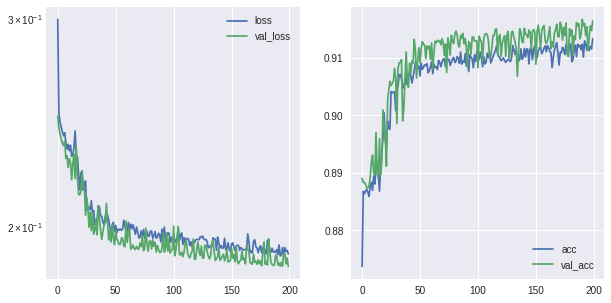

2019-08-08 17:47:10.985608: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-08-08 17:47:11.008397: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2808000000 Hz
2019-08-08 17:47:11.009098: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562f1447b8e0 executing computations on platform Host. Devices:
2019-08-08 17:47:11.009117: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-08-08 17:47:11.131578: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) 

In [10]:
history = model.fit(x_train, y_train, epochs=200, batch_size=1024,  verbose=1, validation_data=(x_test, y_test), callbacks = callbacks)
#model.save("model_tanh_dropout_sigmoid.hdf5")
#from keras.models import load_model # Here I have added in a load section so that I can fit the model once and then can rerun the code later on to test things without having to fit the data every time.
#model = load_model('model_tanh_dropout_sigmoid.hdf5')

In [9]:
predictions = model.predict(xNew)
binMigrations = np.zeros(predictions.shape[0])
unfoldedMass = np.zeros(predictions.shape[0])

#Find which category the model says is most likely to be correct for each event
for i in range(predictions.shape[0]):
    binMigrations[i] = np.where(predictions[i] == np.amax(predictions[i]))[0]

#Convert the category to a migration vector
for i in range(len(binMigrations)):
    if(binMigrations[i]==0):
        binMigrations[i]=0
    if(binMigrations[i]==1):
        binMigrations[i]=1
    if(binMigrations[i]==2):
        binMigrations[i]=-1

unfoldedHisto = ROOT.TH1F("unfoldedHisto", "unfoldedHisto", len(bins)-1, np.array(bins, dtype=float))
genHisto = utils.array2TH1F(genMass, bins, name="genHisto", title="genHisto")
recoHisto = utils.array2TH1F(recoMass, bins, name="recHisto", title="recHisto")

#For each event add 1 entry to the bin predicted by the model
for i in range(len(binMigrations)):
    unfoldedMass[i] = binMigrations[i] + np.searchsorted(bins, recoMass[i])
    unfoldedHisto.AddBinContent(int(unfoldedMass[i]))

canvas = ROOT.TCanvas("canvas", "canvas", 500, 500)
recoHisto.SetLineColor(ROOT.kGreen)
genHisto.SetLineColor(ROOT.kRed)
unfoldedHisto.Draw("hist")
genHisto.Draw("same")
recoHisto.Draw("same")
canvas.BuildLegend()
canvas.Draw()

In [10]:
import math
accuracyCheck=0
for i in range(len(genMass)): 
    #print(np.searchsorted(bins, genMass[i]) - unfoldedMass[i])
    if np.searchsorted(bins, genMass[i]) - unfoldedMass[i]==0:
        accuracyCheck += 1
    
print(100*float(accuracyCheck)/float(len(genMass)))

unfoldedAccuracy = 0
unfoldedCounter = 0
for i in range(len(bins)-1):
    if genHisto.GetBinContent(i) > 0:
        unfoldedAccuracy += (((genHisto.GetBinContent(i) - unfoldedHisto.GetBinContent(i))**2)/genHisto.GetBinError(i)**2)
        unfoldedCounter +=1


unfoldedAccuracy = unfoldedAccuracy/(unfoldedCounter)
print("Unfolded mass chi^2 result", unfoldedAccuracy)

recoAccuracy = 0
recoCounter = 0
for i in range(len(bins)-1):
    if genHisto.GetBinContent(i) > 0:
        recoAccuracy += (((genHisto.GetBinContent(i) - recoHisto.GetBinContent(i))**2)/genHisto.GetBinError(i)**2)
        recoCounter +=1


recoAccuracy = recoAccuracy/(recoCounter)
print("Reconstructed mass chi^2 result", recoAccuracy)
print("Unfolded result / Reconstructed result", recoAccuracy/unfoldedAccuracy)

73.5164221534
('Unfolded mass chi^2 result', 13.150005407581554)
('Reconstructed mass chi^2 result', 181.82283073033116)
('Unfolded result / Reconstructed result', 13.826825548337975)


In [13]:
matrix_histo = ROOT.TH2F("Matrix Histogram", "Generated Z-->l+ l- Invariant Mass; Generated Invariant Mass [GeV]; Reconstructed Invariant Mass [GeV]", nBins, massMin, massMax, nBins, massMin, massMax);
for  i in range(len(recoMass)):
    matrix_histo.Fill(genMass[i], recoMass[i])
    
matrix_canvas = ROOT.TCanvas("matrix canvas", "canvas title", 500, 500)
matrix_histo.SetStats(0);
matrix_canvas.SetRightMargin(0.15);
matrix_canvas.SetLeftMargin(0.15);
matrix_canvas.SetBottomMargin(0.15);
matrix_histo.Draw("COLZ");
matrix_canvas.Draw("HIST");

Warning in <TROOT::Append>: Replacing existing TH1: Matrix Histogram (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: matrix canvas


In [20]:
%%cpp
#include <TError.h>
#include <TMath.h>
#include <TCanvas.h>
#include <TRandom3.h>
#include <TFitter.h>
#include <TF1.h>
#include <TStyle.h>
#include <TVector.h>
#include <TGraph.h>
TUnfold unfold(matrix_histo,TUnfold::kHistMapOutputHoriz,TUnfold::kRegModeSize);
unfold.SetInput(train_detected_histo);
Int_t nScan=50;
Int_t iBest;
Double_t tauMin=1.E-8;
Double_t tauMax=1.E-2;
TSpline *logTauX,*logTauY;
TGraph *lCurve;
iBest=unfold.ScanLcurve(nScan,tauMin,tauMax,&lCurve,&logTauX,&logTauY);
Double_t tau=unfold.GetTau();
unfold.DoUnfold(tau);
TH1D *unfolded=new TH1D("Unfolded",";mass(gen)",nBinsOut,xmin, xmax);
unfold.GetOutput(unfolded);

input_line_56:11:8: error: expected ';' after expression
TUnfold unfold(matrix_histo,TUnfold::kHistMapOutputHoriz,TUnfold::kRegModeSize);
       ^
       ;
input_line_56:11:16: error: use of undeclared identifier 'matrix_histo'
TUnfold unfold(matrix_histo,TUnfold::kHistMapOutputHoriz,TUnfold::kRegModeSize);
               ^
input_line_56:11:29: error: use of undeclared identifier 'TUnfold'
TUnfold unfold(matrix_histo,TUnfold::kHistMapOutputHoriz,TUnfold::kRegModeSize);
                            ^
input_line_56:11:58: error: use of undeclared identifier 'TUnfold'
TUnfold unfold(matrix_histo,TUnfold::kHistMapOutputHoriz,TUnfold::kRegModeSize);
                                                         ^
input_line_56:12:1: error: use of undeclared identifier 'unfold'
unfold.SetInput(train_detected_histo);
^
input_line_56:12:17: error: use of undeclared identifier 'train_detected_histo'
unfold.SetInput(train_detected_histo);
                ^
input_line_56:19:7: error: use of undeclared i

In [22]:
from ROOT import TFile, TTree
from array import array
 
h = ROOT.TH1F( 'h1', 'test', 100, -10., 10. )
 
f = ROOT.TFile( 'test.root', 'recreate' )
t = ROOT.TTree( 't1', 'tree with histos' )
 
maxn = 10
n = array( 'i', [ 0 ] )
d = array( 'f', maxn*[ 0. ] )
t.Branch( 'mynum', n, 'mynum/I' )
t.Branch( 'myval', d, 'myval[mynum]/F' )
 
for i in range(25):
   n[0] = min(i,maxn)
   for j in range(n[0]):
      d[j] = i*0.1+j
   t.Fill()
 
f.Write()
f.Close()